# Race feature importance

Notebook to determine what features of a race have the biggest impact on the participants time

### Load Data

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Preparation
df = pd.read_csv("../data/data_cleaned.csv", low_memory=False)
df = df[df['Event Type']=='Distance']

In [3]:
df.columns

Index(['Runner ID', 'First Name', 'Surname', 'Nat.', 'Gender', 'Age',
       'Age Group', 'Cat', 'YOB', 'Race Count', 'Cumulative Distance KM',
       'Event ID', 'Event', 'Event Type', 'Date', 'Race Location',
       'Elevation Gain', 'Elevation Gain per KM', 'Total Finishers',
       'Male Finishers', 'Female Finishers', 'Time Seconds Winner',
       'Distance Winner', 'Rank', 'Rank M/F', 'Cat. Rank', 'Finish Percentage',
       'Performance Ratio', 'Distance/Time', 'Distance KM', 'Terrain',
       'Time Seconds Finish', 'Distance Finish', 'Average Speed',
       'Avg.Speed km/h'],
      dtype='object')

### Features

In [27]:
# 2. Feature Engineering
def engineer_features(df):
    df['Month'] = pd.to_datetime(df['Date']).dt.month
    
    # Encode categorical variables
    df = pd.get_dummies(df, columns=['Terrain', 'Gender', 'Event Type'])
    
    return df

df_engineered = engineer_features(df)

# Select features for the model
features = ['Age', 'Distance KM', 'Elevation Gain', 'Elevation Gain per KM', 'Month', 
            'Race Count', 'Cumulative Distance KM',
            'Total Finishers', 'Performance Ratio', 'Finish Percentage', 
            'Terrain_road', 'Terrain_trail', 'Terrain_track', 'Gender_M', 'Gender_F',
            'Event Type_Distance']

In [28]:
X = df_engineered[features]
y_average = df_engineered.groupby('Event ID')['Time Seconds Finish'].transform('mean')
y_median = df_engineered.groupby('Event ID')['Time Seconds Finish'].transform('median')

df_winner = df_engineered[df_engineered['Rank']==1]
X_winner = df_winner[features]
y_winner = df_winner['Time Seconds Finish']

# Speed data
y_average_speed = df_engineered.groupby('Event ID')['Average Speed'].transform('mean')
y_median_speed = df_engineered.groupby('Event ID')['Average Speed'].transform('median')

y_winner_speed = df_winner['Average Speed']

### Random Forest model

In [ ]:
# 3. Model Building
def build_and_evaluate_model(X, y, model_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({'feature': features, 'importance': importance})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    print(f"\nFeature Importance for {model_name}:")
    print(feature_importance)
    
    return feature_importance

In [31]:
# Build models for fastest, average, and median times
fastest_importance = build_and_evaluate_model(X_winner, y_winner, "Fastest Time")
average_importance = build_and_evaluate_model(X, y_average, "Average Time")
median_importance = build_and_evaluate_model(X, y_median, "Median Time")


Feature Importance for Fastest Time:
                   feature  importance
1              Distance KM    0.860443
7          Total Finishers    0.020856
0                      Age    0.019431
3    Elevation Gain per KM    0.019000
6   Cumulative Distance KM    0.017300
9        Finish Percentage    0.015229
5               Race Count    0.012889
11           Terrain_trail    0.008791
10            Terrain_road    0.008683
4                    Month    0.008535
2           Elevation Gain    0.007321
13                Gender_M    0.000758
14                Gender_F    0.000546
8        Performance Ratio    0.000125
12           Terrain_track    0.000093
15     Event Type_Distance    0.000000

Feature Importance for Average Time:
                   feature  importance
1              Distance KM    0.871486
2           Elevation Gain    0.033667
3    Elevation Gain per KM    0.030811
7          Total Finishers    0.022198
8        Performance Ratio    0.014050
4                    Month 

In [33]:
fastest_importance_speed = build_and_evaluate_model(X_winner, y_winner_speed, "Fastest Speed")
average_importance_speed = build_and_evaluate_model(X, y_average_speed, "Average Speed")
median_importance_speed = build_and_evaluate_model(X, y_median_speed, "Median Speed")


Feature Importance for Fastest Speed:
                   feature  importance
1              Distance KM    0.412650
7          Total Finishers    0.117848
2           Elevation Gain    0.094276
0                      Age    0.071383
3    Elevation Gain per KM    0.061969
6   Cumulative Distance KM    0.061170
9        Finish Percentage    0.051961
4                    Month    0.051325
5               Race Count    0.039916
11           Terrain_trail    0.014192
10            Terrain_road    0.006653
8        Performance Ratio    0.006095
14                Gender_F    0.004486
13                Gender_M    0.003912
12           Terrain_track    0.002165
15     Event Type_Distance    0.000000

Feature Importance for Average Speed:
                   feature  importance
2           Elevation Gain    0.357247
7          Total Finishers    0.177993
3    Elevation Gain per KM    0.137175
1              Distance KM    0.134740
4                    Month    0.069558
8        Performance Rati

### Plots

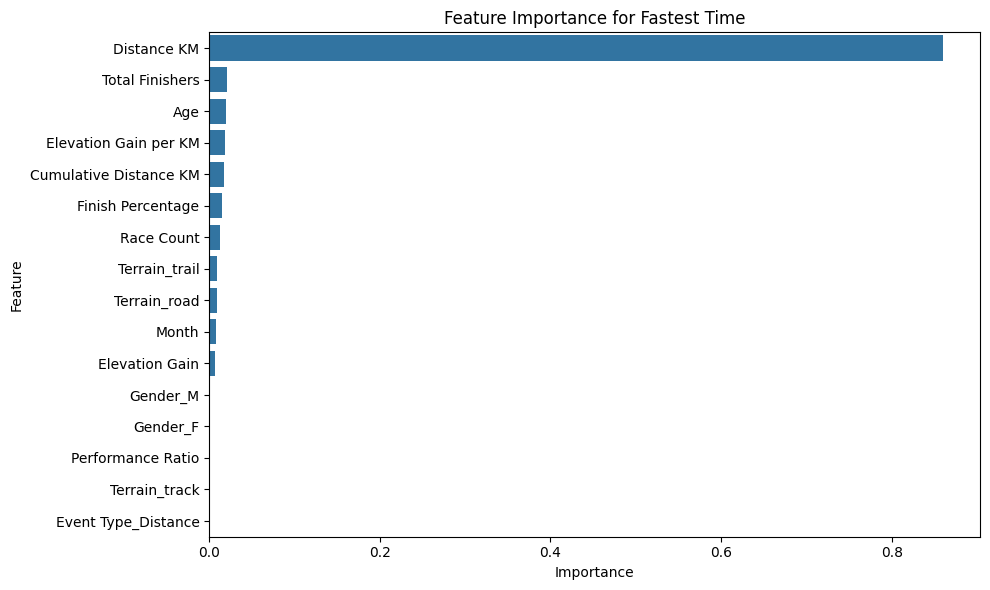

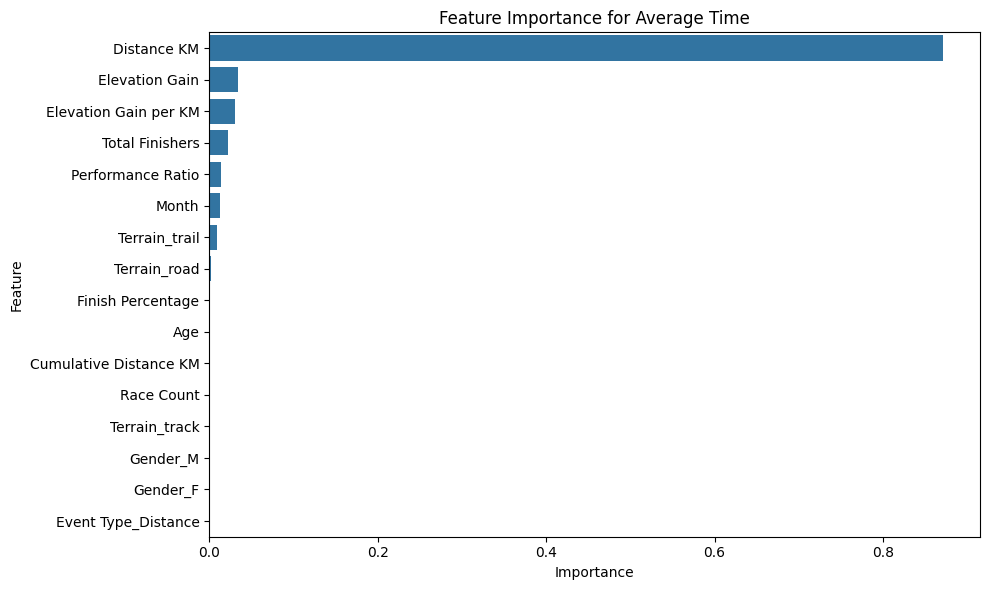

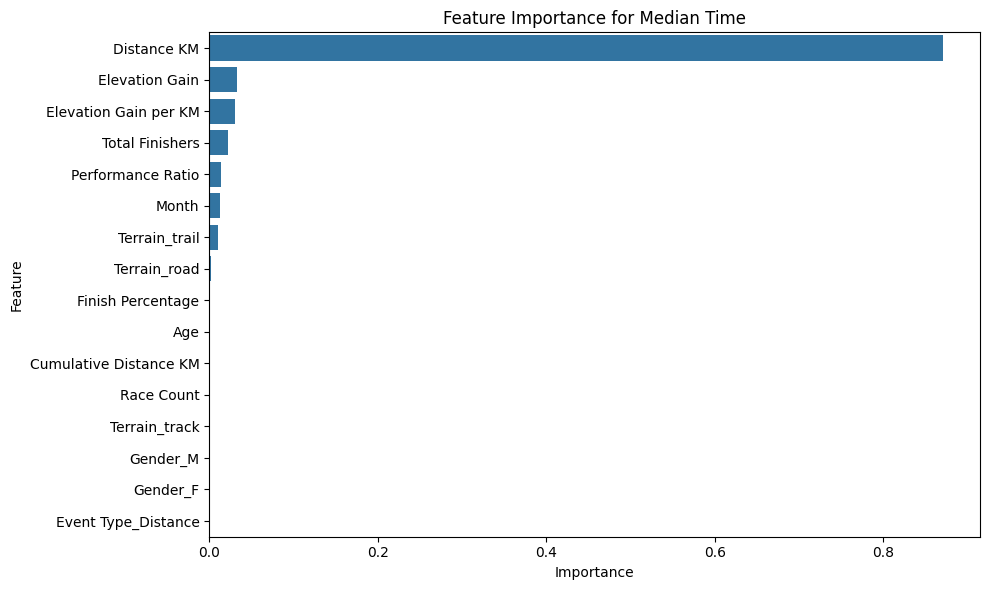

<Figure size 1200x800 with 0 Axes>

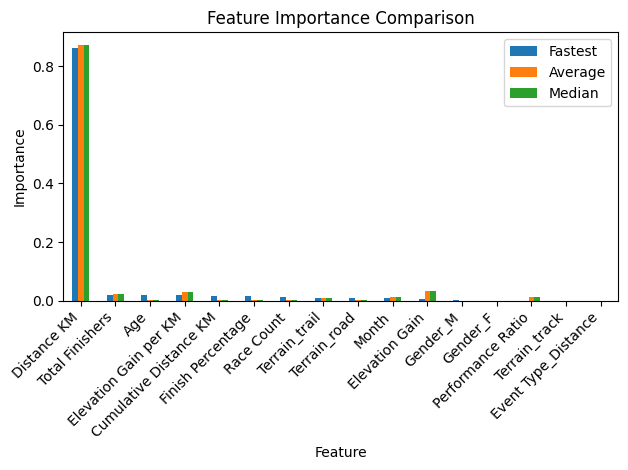


Overall Feature Importance:
                   feature  overall_importance
0              Distance KM            0.867705
3    Elevation Gain per KM            0.026673
10          Elevation Gain            0.024614
1          Total Finishers            0.021875
9                    Month            0.011066
7            Terrain_trail            0.009364
13       Performance Ratio            0.009281
2                      Age            0.007350
4   Cumulative Distance KM            0.006290
5        Finish Percentage            0.006054
6               Race Count            0.004773
8             Terrain_road            0.004349
11                Gender_M            0.000290
12                Gender_F            0.000219
14           Terrain_track            0.000097
15     Event Type_Distance            0.000000


In [32]:
# 4. & 5. Feature Importance Analysis and Visualization
def plot_feature_importance(importance_df, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title(f"Feature Importance for {title}")
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

plot_feature_importance(fastest_importance, "Fastest Time")
plot_feature_importance(average_importance, "Average Time")
plot_feature_importance(median_importance, "Median Time")

# Compare feature importances across models
all_importances = pd.merge(fastest_importance, average_importance, on='feature', suffixes=('_fastest', '_average'))
all_importances = pd.merge(all_importances, median_importance, on='feature', suffixes=('', '_median'))
all_importances.columns = ['feature', 'importance_fastest', 'importance_average', 'importance_median']

plt.figure(figsize=(12, 8))
all_importances.set_index('feature').plot(kind='bar')
plt.title("Feature Importance Comparison")
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.legend(['Fastest', 'Average', 'Median'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate and print overall importance
all_importances['overall_importance'] = all_importances[['importance_fastest', 'importance_average', 'importance_median']].mean(axis=1)
overall_importance = all_importances.sort_values('overall_importance', ascending=False)
print("\nOverall Feature Importance:")
print(overall_importance[['feature', 'overall_importance']])

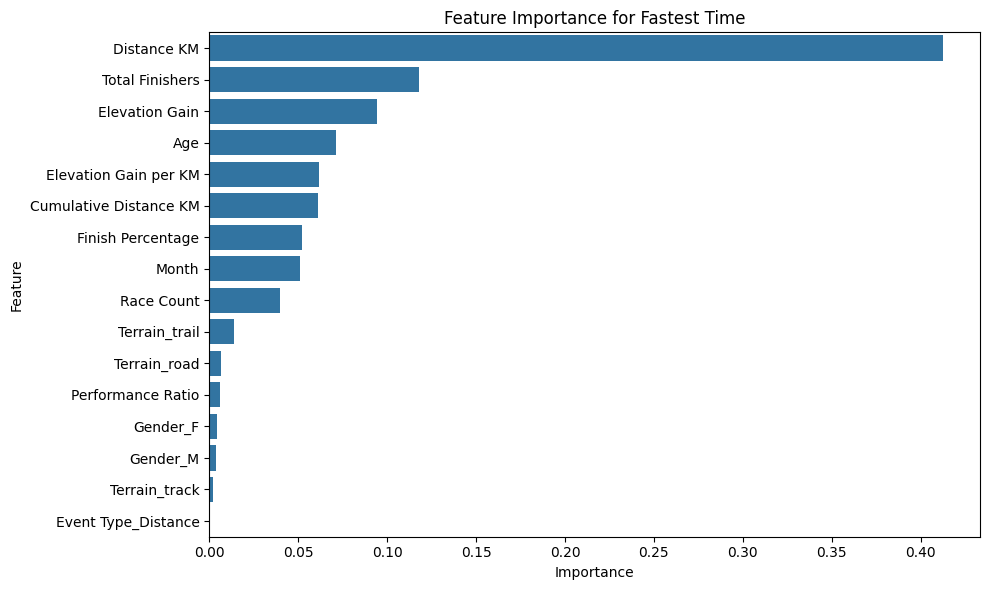

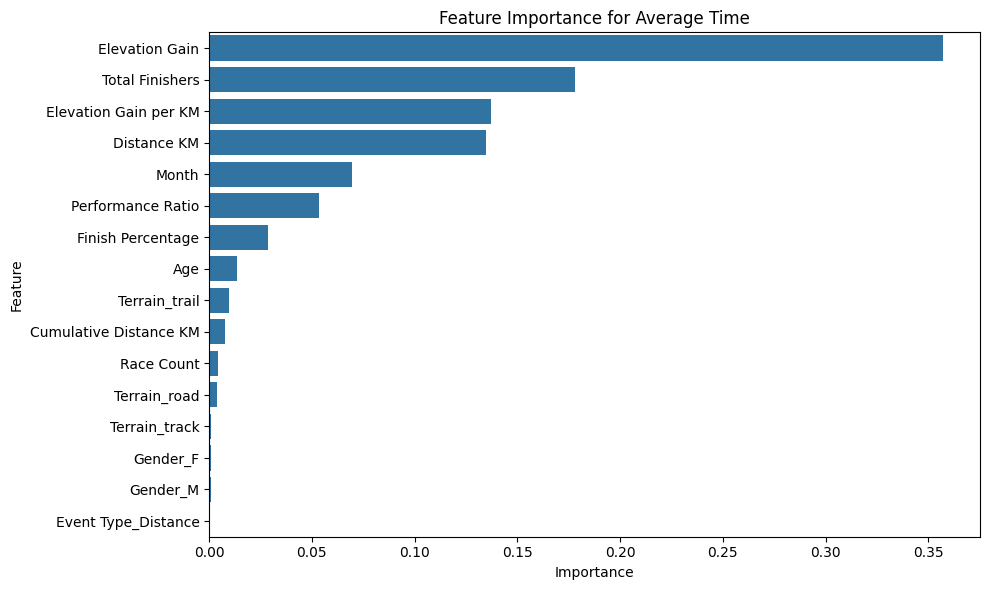

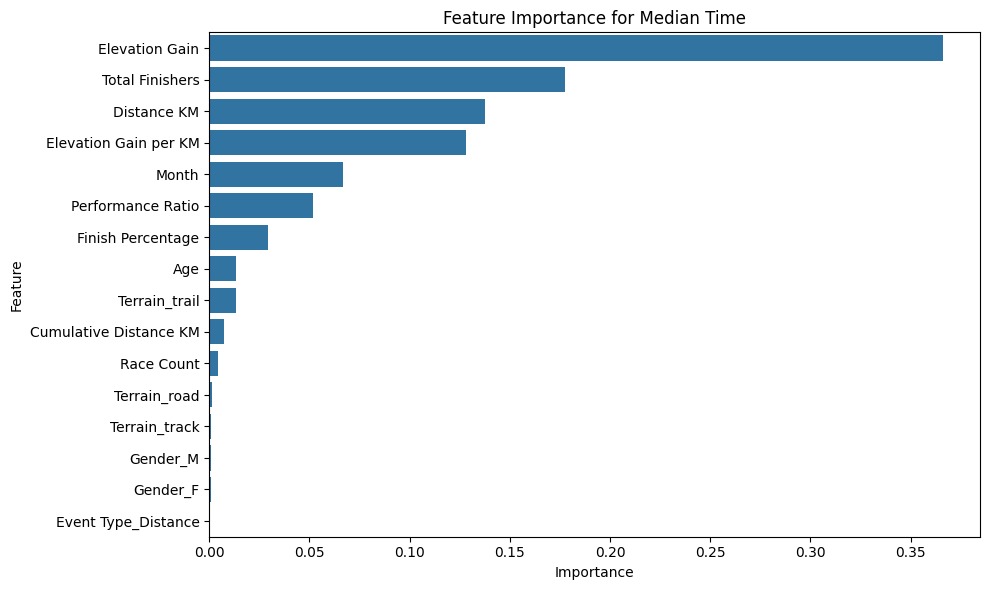

In [34]:
plot_feature_importance(fastest_importance_speed, "Fastest Time")
plot_feature_importance(average_importance_speed, "Average Time")
plot_feature_importance(median_importance_speed, "Median Time")

<Figure size 1200x800 with 0 Axes>

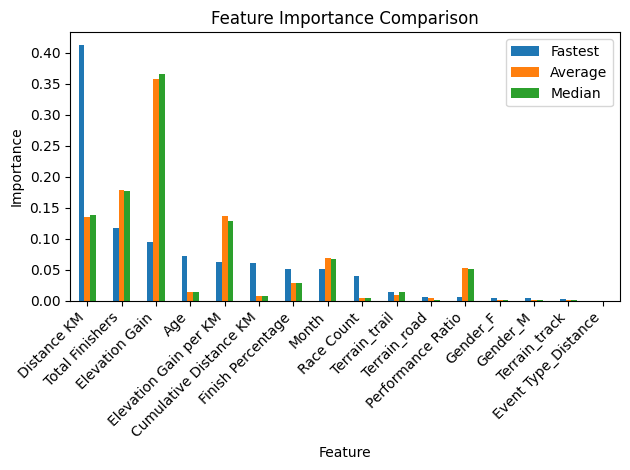


Overall Feature Importance:
                   feature  overall_importance
2           Elevation Gain            0.272615
0              Distance KM            0.228347
1          Total Finishers            0.157765
4    Elevation Gain per KM            0.109137
7                    Month            0.062497
11       Performance Ratio            0.037034
6        Finish Percentage            0.036700
3                      Age            0.032816
5   Cumulative Distance KM            0.025436
8               Race Count            0.016110
9            Terrain_trail            0.012356
10            Terrain_road            0.003949
12                Gender_F            0.002005
13                Gender_M            0.001813
14           Terrain_track            0.001421
15     Event Type_Distance            0.000000


In [35]:

# Compare feature importances across models
all_importances_speed = pd.merge(fastest_importance_speed, average_importance_speed, on='feature', suffixes=('_fastest', '_average'))
all_importances_speed = pd.merge(all_importances_speed, median_importance_speed, on='feature', suffixes=('', '_median'))
all_importances_speed.columns = ['feature', 'importance_fastest', 'importance_average', 'importance_median']

plt.figure(figsize=(12, 8))
all_importances_speed.set_index('feature').plot(kind='bar')
plt.title("Feature Importance Comparison")
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.legend(['Fastest', 'Average', 'Median'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate and print overall importance
all_importances_speed['overall_importance'] = all_importances_speed[['importance_fastest', 'importance_average', 'importance_median']].mean(axis=1)
overall_importance_speed = all_importances_speed.sort_values('overall_importance', ascending=False)
print("\nOverall Feature Importance:")
print(overall_importance_speed[['feature', 'overall_importance']])